<a href="https://colab.research.google.com/github/choi-yh/Pyhon_ML_Guide/blob/master/04_08_%EC%BA%90%EA%B8%80_%EC%82%B0%ED%83%84%EB%8D%B0%EB%A5%B4_%EA%B3%A0%EA%B0%9D_%EB%A7%8C%EC%A1%B1_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 레이블: `TARGET` (1: 불만을 가진 고객, 0: 만족한 고객)
* 370개의 피처 (피처 이름은 익명 처리)
* 성능 평가는 **ROC-AUC**

https://www.kaggle.com/cast42/exploring-features 필사



### 데이터 전처리

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8, 6)

import warnings
warnings.filterwarnings('ignore')

In [9]:
train = pd.read_csv("/gdrive/My Drive/Python/파이썬_머신러닝_완벽_가이드/data/santander-customer-satisfaction/train.csv")
test = pd.read_csv("/gdrive/My Drive/Python/파이썬_머신러닝_완벽_가이드/data/santander-customer-satisfaction/test.csv")
print('dataset shape: ', train.shape)
train.head(3)

dataset shape:  (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.0,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [8]:
# Null 값은 없다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [11]:
# 레이블 분포 확인
# 0: 만족한 고객, 1: 불만족 고객
# 만족한 고객이 96%로 대부분이다. -> imbalanced data
df = pd.DataFrame(train['TARGET'].value_counts())
df['Percentage'] = 100 * df['TARGET'] / train.shape[0]
df

,TARGET,Percentage
0,73012,96.043147
1,3008,3.956853


In [12]:
# 피처 분포 확인
train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

#### var3: nationality of the customer (고객의 국적으로 유추됨)

In [ ]:
train['var3'].value_counts()[:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

In [16]:
# -999999 값이 116개 존재한다. 다른 값과 편차가 크기 때문에 가장 많은 2로 변환
train['var3'] = train['var3'].replace(-999999, 2)
train[train['var3'] == -999999].shape

(0, 371)

#### 피처와 레이블 분리 / Add feature that counts the number of zeros in a row (열마다 0을 세는 피처..? 왜 필요..?)

In [20]:
X = train.drop(['ID', 'TARGET'], axis=1)
y = train['TARGET']

X['n0'] = (X==0).sum(axis=1)
train['n0'] = X['n0']

In [19]:
print("피처 데이터 shape: ", X.shape)

피처 데이터 shape:  (76020, 369)


### EDA

#### num_var4: number of bank products

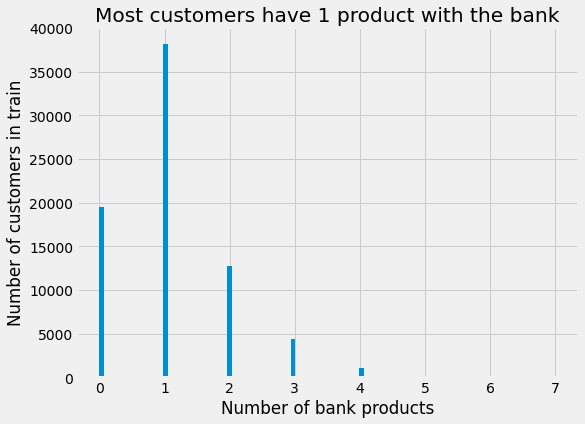

In [30]:
# According to dmi3kno 
# num_var4 is the number of products. Let's plot the distribution:

train['num_var4'].hist(bins=100)
plt.xlabel('Number of bank products')
plt.ylabel('Number of customers in train')
plt.title('Most customers have 1 product with the bank')
plt.show()

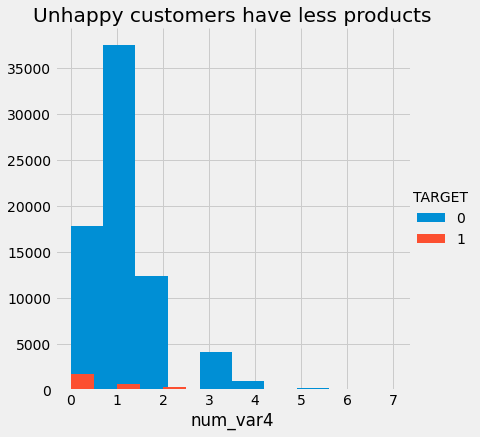

In [33]:
# Let's look at the density of th of happy/unhappy customers in function of the number of bank products
# FacetGrid는 조건부 관계를 위한 Multi-Plot grid 그리는 함수
sns.FacetGrid(train, hue='TARGET', size=6).map(plt.hist, 'num_var4').add_legend()
plt.title('Unhappy customers have less products')
plt.show()

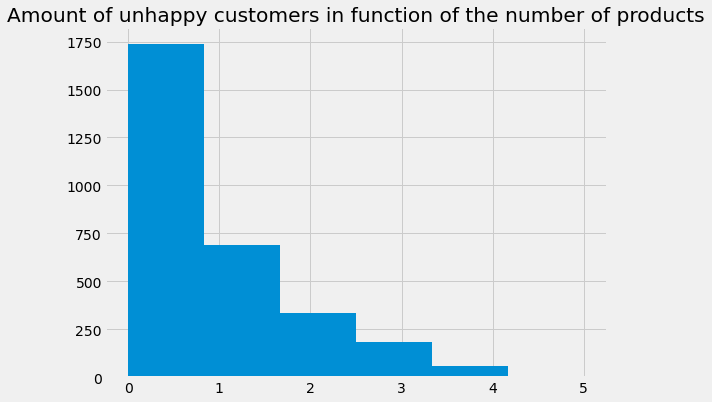

In [39]:
train[train['TARGET'] == 1]['num_var4'].hist(bins=6)
plt.title('Amount of unhappy customers in function of the number of products')
plt.show()

#### Var38

var38 is important according to XGBOOST see https://www.kaggle.com/cast42/santander-customer-satisfaction/xgboost-with-early-stopping/files

Also RFC thinks var38 is important see https://www.kaggle.com/tks0123456789/santander-customer-satisfaction/data-exploration/notebook

Var38 is suspected to be the mortage value with the bank. If the mortage is with another bank the national average is used. See https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19895/var38-is-mortgage-value

dmi3kno says that var38 is value of the customer: https://www.kaggle.com/cast42/santander-customer-satisfaction/exploring-features/comments#115223

In [40]:
train['var38'].describe()

count    7.602000e+04
mean     1.172358e+05
std      1.826646e+05
min      5.163750e+03
25%      6.787061e+04
50%      1.064092e+05
75%      1.187563e+05
max      2.203474e+07
Name: var38, dtype: float64

In [44]:
# How is var38 looking when customer is unhappy?
train.loc[train['TARGET'] == 1, 'var38'].describe()

count    3.008000e+03
mean     9.967828e+04
std      1.063098e+05
min      1.113663e+04
25%      5.716094e+04
50%      8.621997e+04
75%      1.173110e+05
max      3.988595e+06
Name: var38, dtype: float64

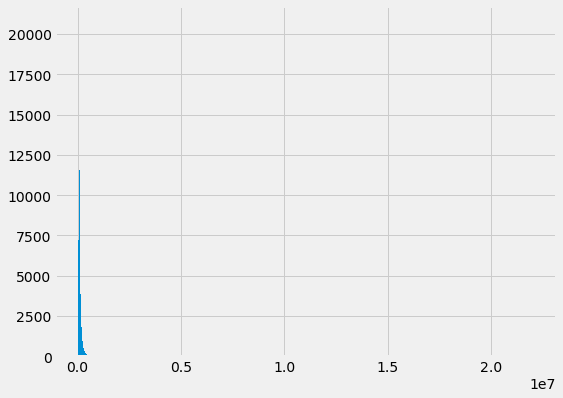

In [46]:
# Histogram for var38 is no normal distributed
train['var38'].hist(bins=1000);

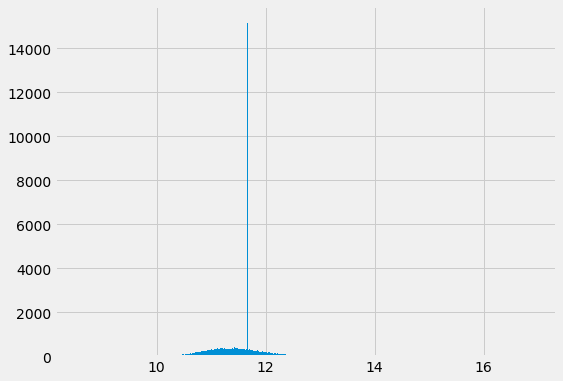

In [47]:
train['var38'].map(np.log).hist(bins=1000);

In [48]:
# where is the spike between 11 and 12 in the log plot?
# 가운데 삐쭉 뻗은 선
train['var38'].map(np.log).mode() # pd.DataFrame.mode(): 최빈값

0    11.672584
dtype: float64

In [49]:
# What are the most common values for var38?
train['var38'].value_counts()

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
                 ...  
318211.440000        1
73069.260000         1
36425.370000         1
163515.900000        1
159395.520000        1
Name: var38, Length: 57736, dtype: int64

In [51]:
# the most common value is very close to the mean of the other values
# 최빈값이 다른 값들의 평균인지 -> 거의 유사함
train['var38'][train['var38'] != 117310.979016].mean()

117235.80943035621

In [52]:
# what if we exclude the most common value
train.loc[~np.isclose(train.var38, 117310.979016), 'var38'].value_counts()

451931.22    16
463625.16    12
288997.44    11
104563.80    11
236690.34     8
             ..
384796.59     1
108436.56     1
41489.49      1
90218.19      1
153559.74     1
Name: var38, Length: 57734, dtype: int64

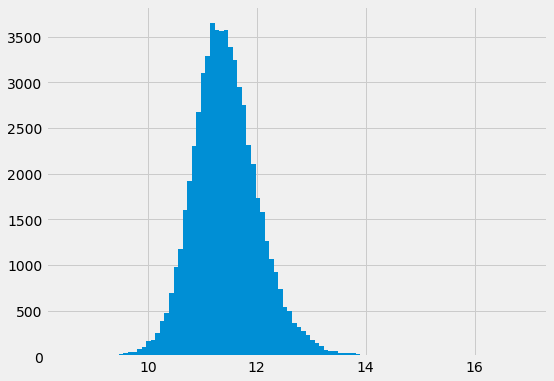

In [53]:
# Look at the distribution
train.loc[~np.isclose(train['var38'], 117310.979016), 'var38'].map(np.log).hist(bins=100);

In [54]:
# Above plot suggest we split up var38 into two variables
# var38mc == 1 when var38 has the most common value and 0 otherwise
# logvar38 is log transformed feature when var38mc is 0, zero otherwise
# 최빈값과 아닌 값으로 나눠서 로그 스케일 적용

train['var38mc'] = np.isclose(train['var38'], 117310.979016) # 최빈값
train['logvar38'] = train.loc[~train['var38mc'], 'var38'].map(np.log) # 아닌 값들 로그 스케일
train.loc[train['var38mc'], 'logvar38'] = 0

In [56]:
# Check for nan's
print('Number of nan in var38mc: ', train['var38mc'].isna().sum())
print('Number of nan in logvar38: ', train['logvar38'].isna().sum())

Number of nan in var38mc:  0
Number of nan in logvar38:  0


#### var15

The most important feature for XGBoost is var15. Accordint to a Kaggle form post *var15 is the age of the customer*. Let's explor var15

In [57]:
train['var15'].describe()

count    76020.000000
mean        33.212865
std         12.956486
min          5.000000
25%         23.000000
50%         28.000000
75%         40.000000
max        105.000000
Name: var15, dtype: float64

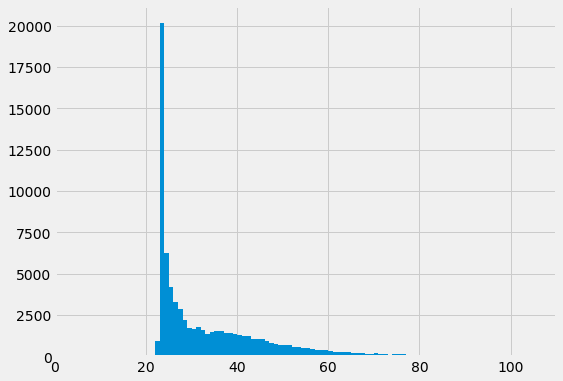

In [58]:
# Looks more normal, plot the histogram
train['var15'].hist(bins=100);

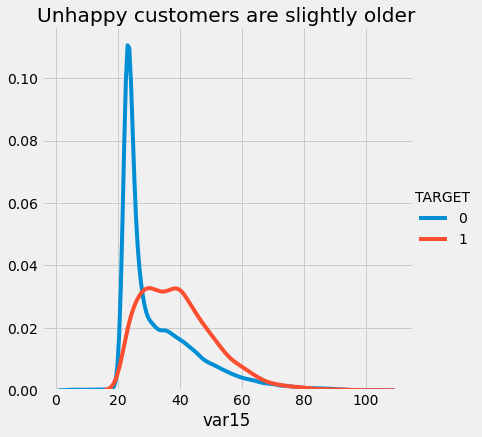

In [63]:
# Let's look at the density of the age of happy/unhappy customers
sns.FacetGrid(train, hue='TARGET', size=6).map(sns.kdeplot, 'var15').add_legend()
plt.title('Unhappy customers are slightly older')
plt.show()

#### saldo_var30

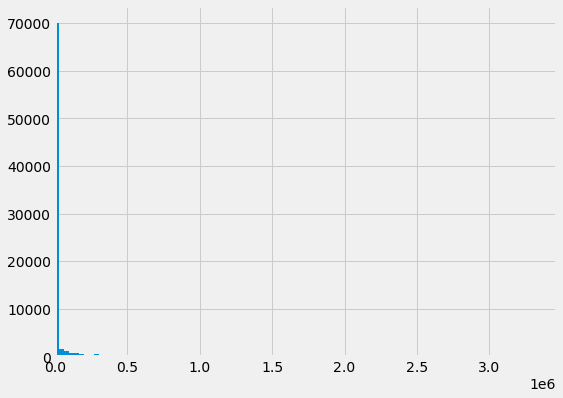

In [64]:
train['saldo_var30'].hist(bins=100)
plt.xlim(0, train['saldo_var30'].max())
plt.show()

In [72]:
# improve the plot by making the x axis logarithmic
train['log_saldo_var30'] = train['saldo_var30'].loc[train['saldo_var30'] != 0].map(np.log)

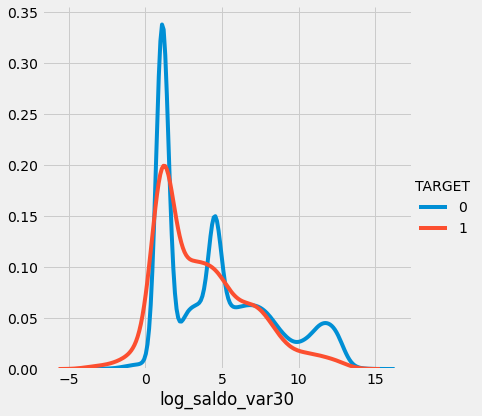

In [73]:
# Let's look at the density of the age of happy/unhappy customers for saldo_var30
sns.FacetGrid(train, hue='TARGET', size=6).map(sns.kdeplot, 'log_saldo_var30').add_legend()
plt.show()

#### Explort the interaction between var15 (age) and var38

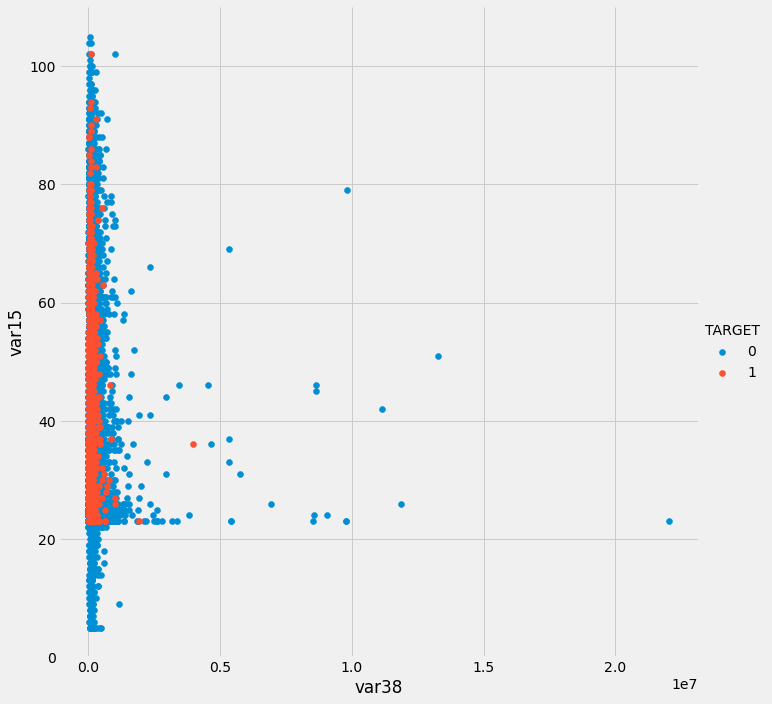

In [74]:
sns.FacetGrid(train, hue='TARGET', size=10).map(plt.scatter, 'var38', 'var15').add_legend();

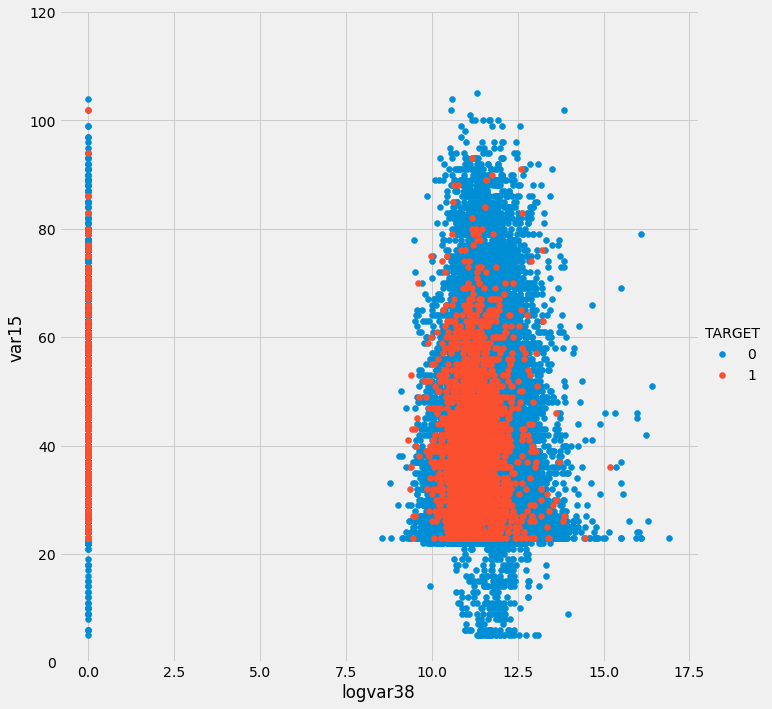

In [75]:
sns.FacetGrid(train, hue='TARGET', size=10).map(plt.scatter, 'logvar38', 'var15').add_legend()
plt.ylim([0, 120]); # Age must be positive

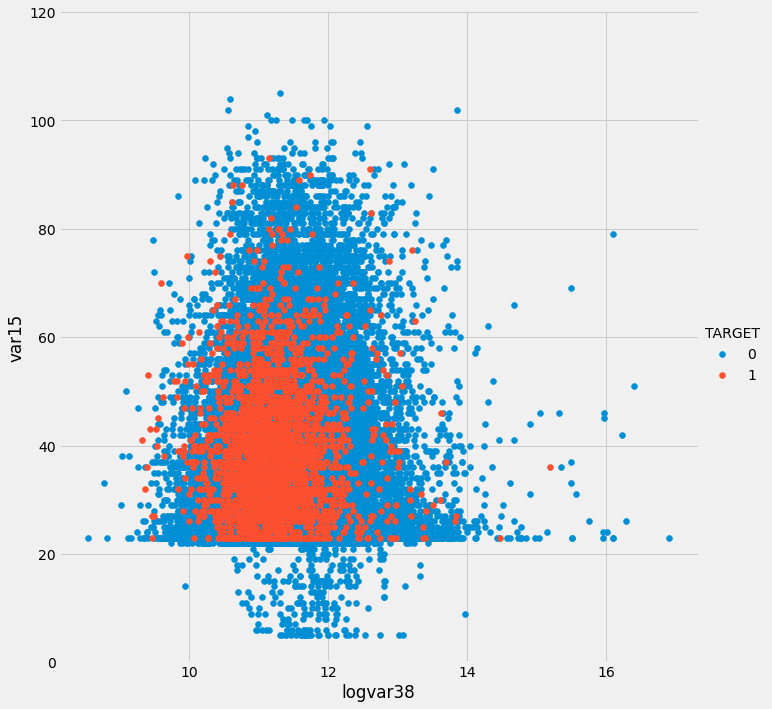

In [76]:
# Exclude most common value for var38
sns.FacetGrid(train[~train['var38mc']], hue='TARGET', size=10).map(plt.scatter, 'logvar38', 'var15').add_legend()
plt.ylim([0, 120]);

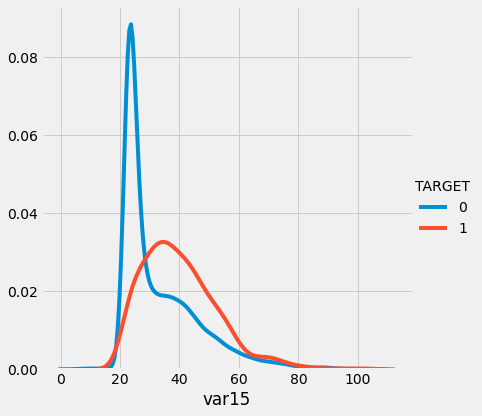

In [77]:
# What is distribution of the age when var38 has it's most common value?
# var38이 가장 많은 값을 가지는 나이 분포?
sns.FacetGrid(train[train['var38mc']], hue='TARGET', size=6).map(sns.kdeplot, 'var15').add_legend();

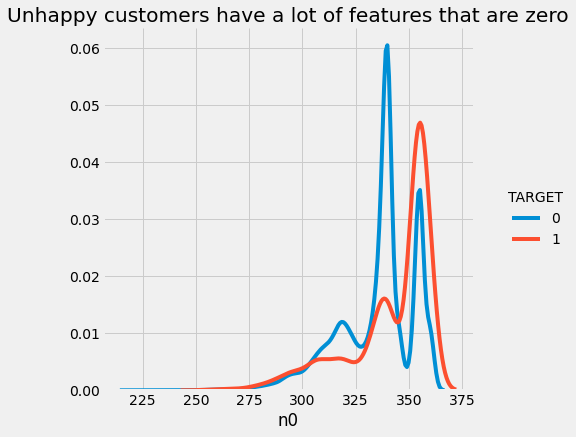

In [81]:
# What is density of n0?
sns.FacetGrid(train, hue='TARGET', size=6).map(sns.kdeplot, 'n0').add_legend()
plt.title('Unhappy customers have a lot of features that are zero');

### Select the most important features

In [83]:
from sklearn.feature_selection import SelectPercentile
# f_classif: Compute the ANOVA F-value for the provided sample.
# chi2: Compute chi-squared stats between each non-negative feature and class.
from sklearn.feature_selection import f_classif, chi2
from sklearn.preprocessing import Binarizer, scale

# First select features based on chi2 and f_classif
p = 3

X_bin = Binarizer().fit_transform(scale(X))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(X, y)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i, f in enumerate(X.columns) if chi2_selected[i] ]
print('Chie2 selected {} features \n{}\n'.format(chi2_selected.sum(), chi2_selected_features))

f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i, f in enumerate(X.columns) if f_classif_selected[i] ]
print('F_classif selected {} features \n{}\n'.format(f_classif_selected.sum(), f_classif_selected_features))

selected = chi2_selected & f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))

features = [ f for f, s in zip(X.columns, selected) if s]
print(features)

Chie2 selected 12 features 
['var15', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var5', 'num_var8_0', 'num_var30_0', 'num_var30', 'num_var42', 'saldo_var30', 'var36', 'num_meses_var5_ult3']

F_classif selected 12 features 
['var15', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var4', 'num_var5', 'num_var30', 'num_var35', 'num_var42', 'var36', 'num_meses_var5_ult3', 'n0']

Chi2 & F_classif selected 9 features
['var15', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var5', 'num_var30', 'num_var42', 'var36', 'num_meses_var5_ult3']


In [84]:
# Make a dataframe with the selected features and the target variable
X_sel = train[features + ['TARGET']]

#### var36

In [85]:
X_sel['var36'].value_counts()

99    30064
3     22177
1     14664
2      8704
0       411
Name: var36, dtype: int64

var36 is most of the times 99 or [0, 1, 2, 3]

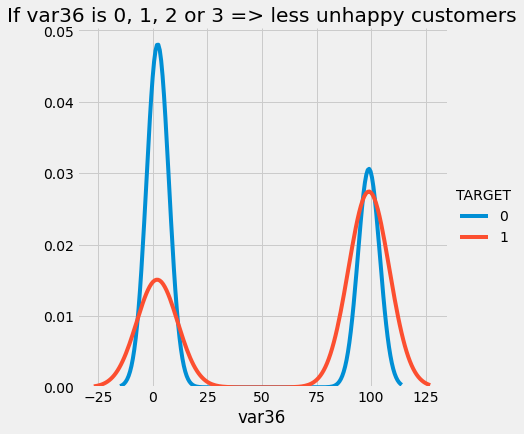

In [86]:
# Let's plot the density in function of the target variable
sns.FacetGrid(train, hue='TARGET', size=6).map(sns.kdeplot, 'var36').add_legend()
plt.title('If var36 is 0, 1, 2 or 3 => less unhappy customers');

In above plot we see that the density of unhappy customers is lower when var36 is not 99

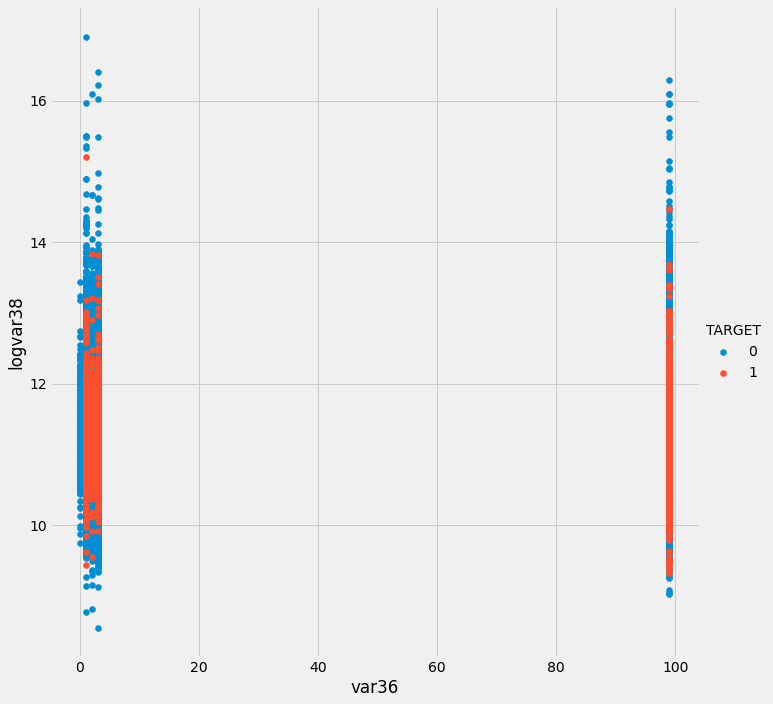

In [87]:
# var36 in function of var38 (most common value excluded)
sns.FacetGrid(train[~train['var38mc']], hue='TARGET', size=10).map(plt.scatter, 'var36', 'logvar38').add_legend();

Let's seperate that in tow plots

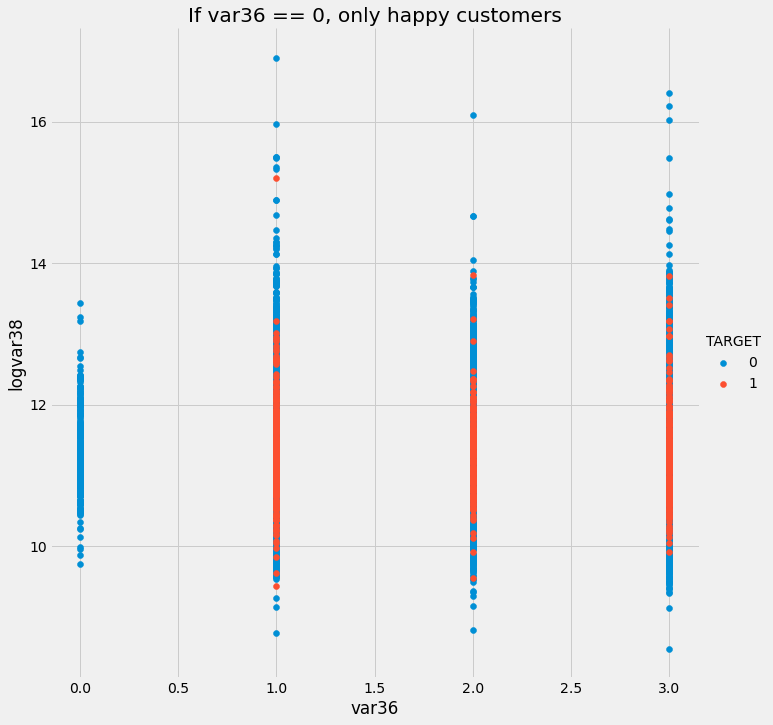

In [88]:
sns.FacetGrid(train[(~train.var38mc) & (train.var36 < 4)], hue='TARGET', size=10).map(plt.scatter, 'var36', 'logvar38').add_legend()
plt.title('If var36 == 0, only happy customers');

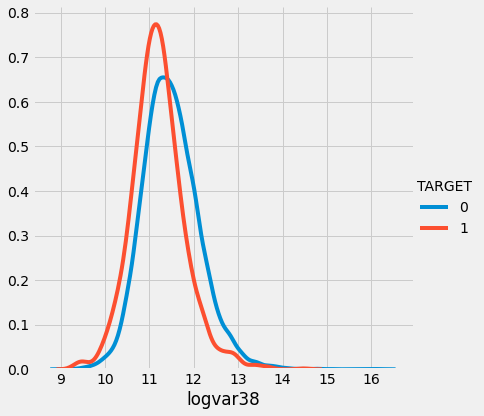

In [89]:
# Let's plot the density in function of the target variable, when var36 = 99
sns.FacetGrid(train[(~train.var38mc) & (train.var36 == 99)], hue='TARGET', size=6).map(sns.kdeplot, 'logvar38').add_legend();

#### num_var5

In [90]:
train['num_var5'].value_counts()

3     50265
0     25561
6       190
9         3
15        1
Name: num_var5, dtype: int64

In [91]:
train[train.TARGET == 1].num_var5.value_counts()

0    1959
3    1042
6       7
Name: num_var5, dtype: int64

In [92]:
train[train.TARGET == 0].num_var5.value_counts()

3     49223
0     23602
6       183
9         3
15        1
Name: num_var5, dtype: int64

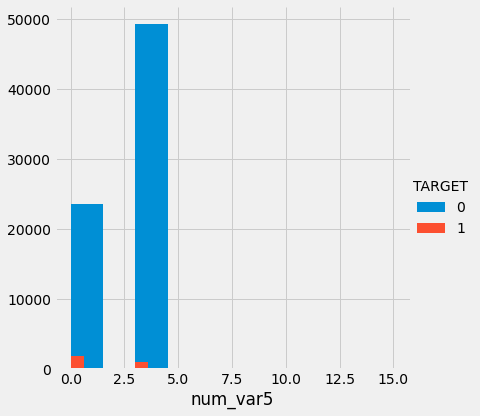

In [94]:
sns.FacetGrid(train, hue='TARGET', size=6).map(plt.hist, 'num_var5').add_legend();

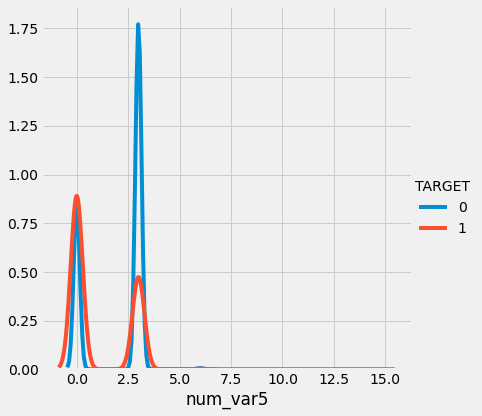

In [95]:
sns.FacetGrid(train, hue='TARGET', size=6).map(sns.kdeplot, 'num_var5').add_legend();

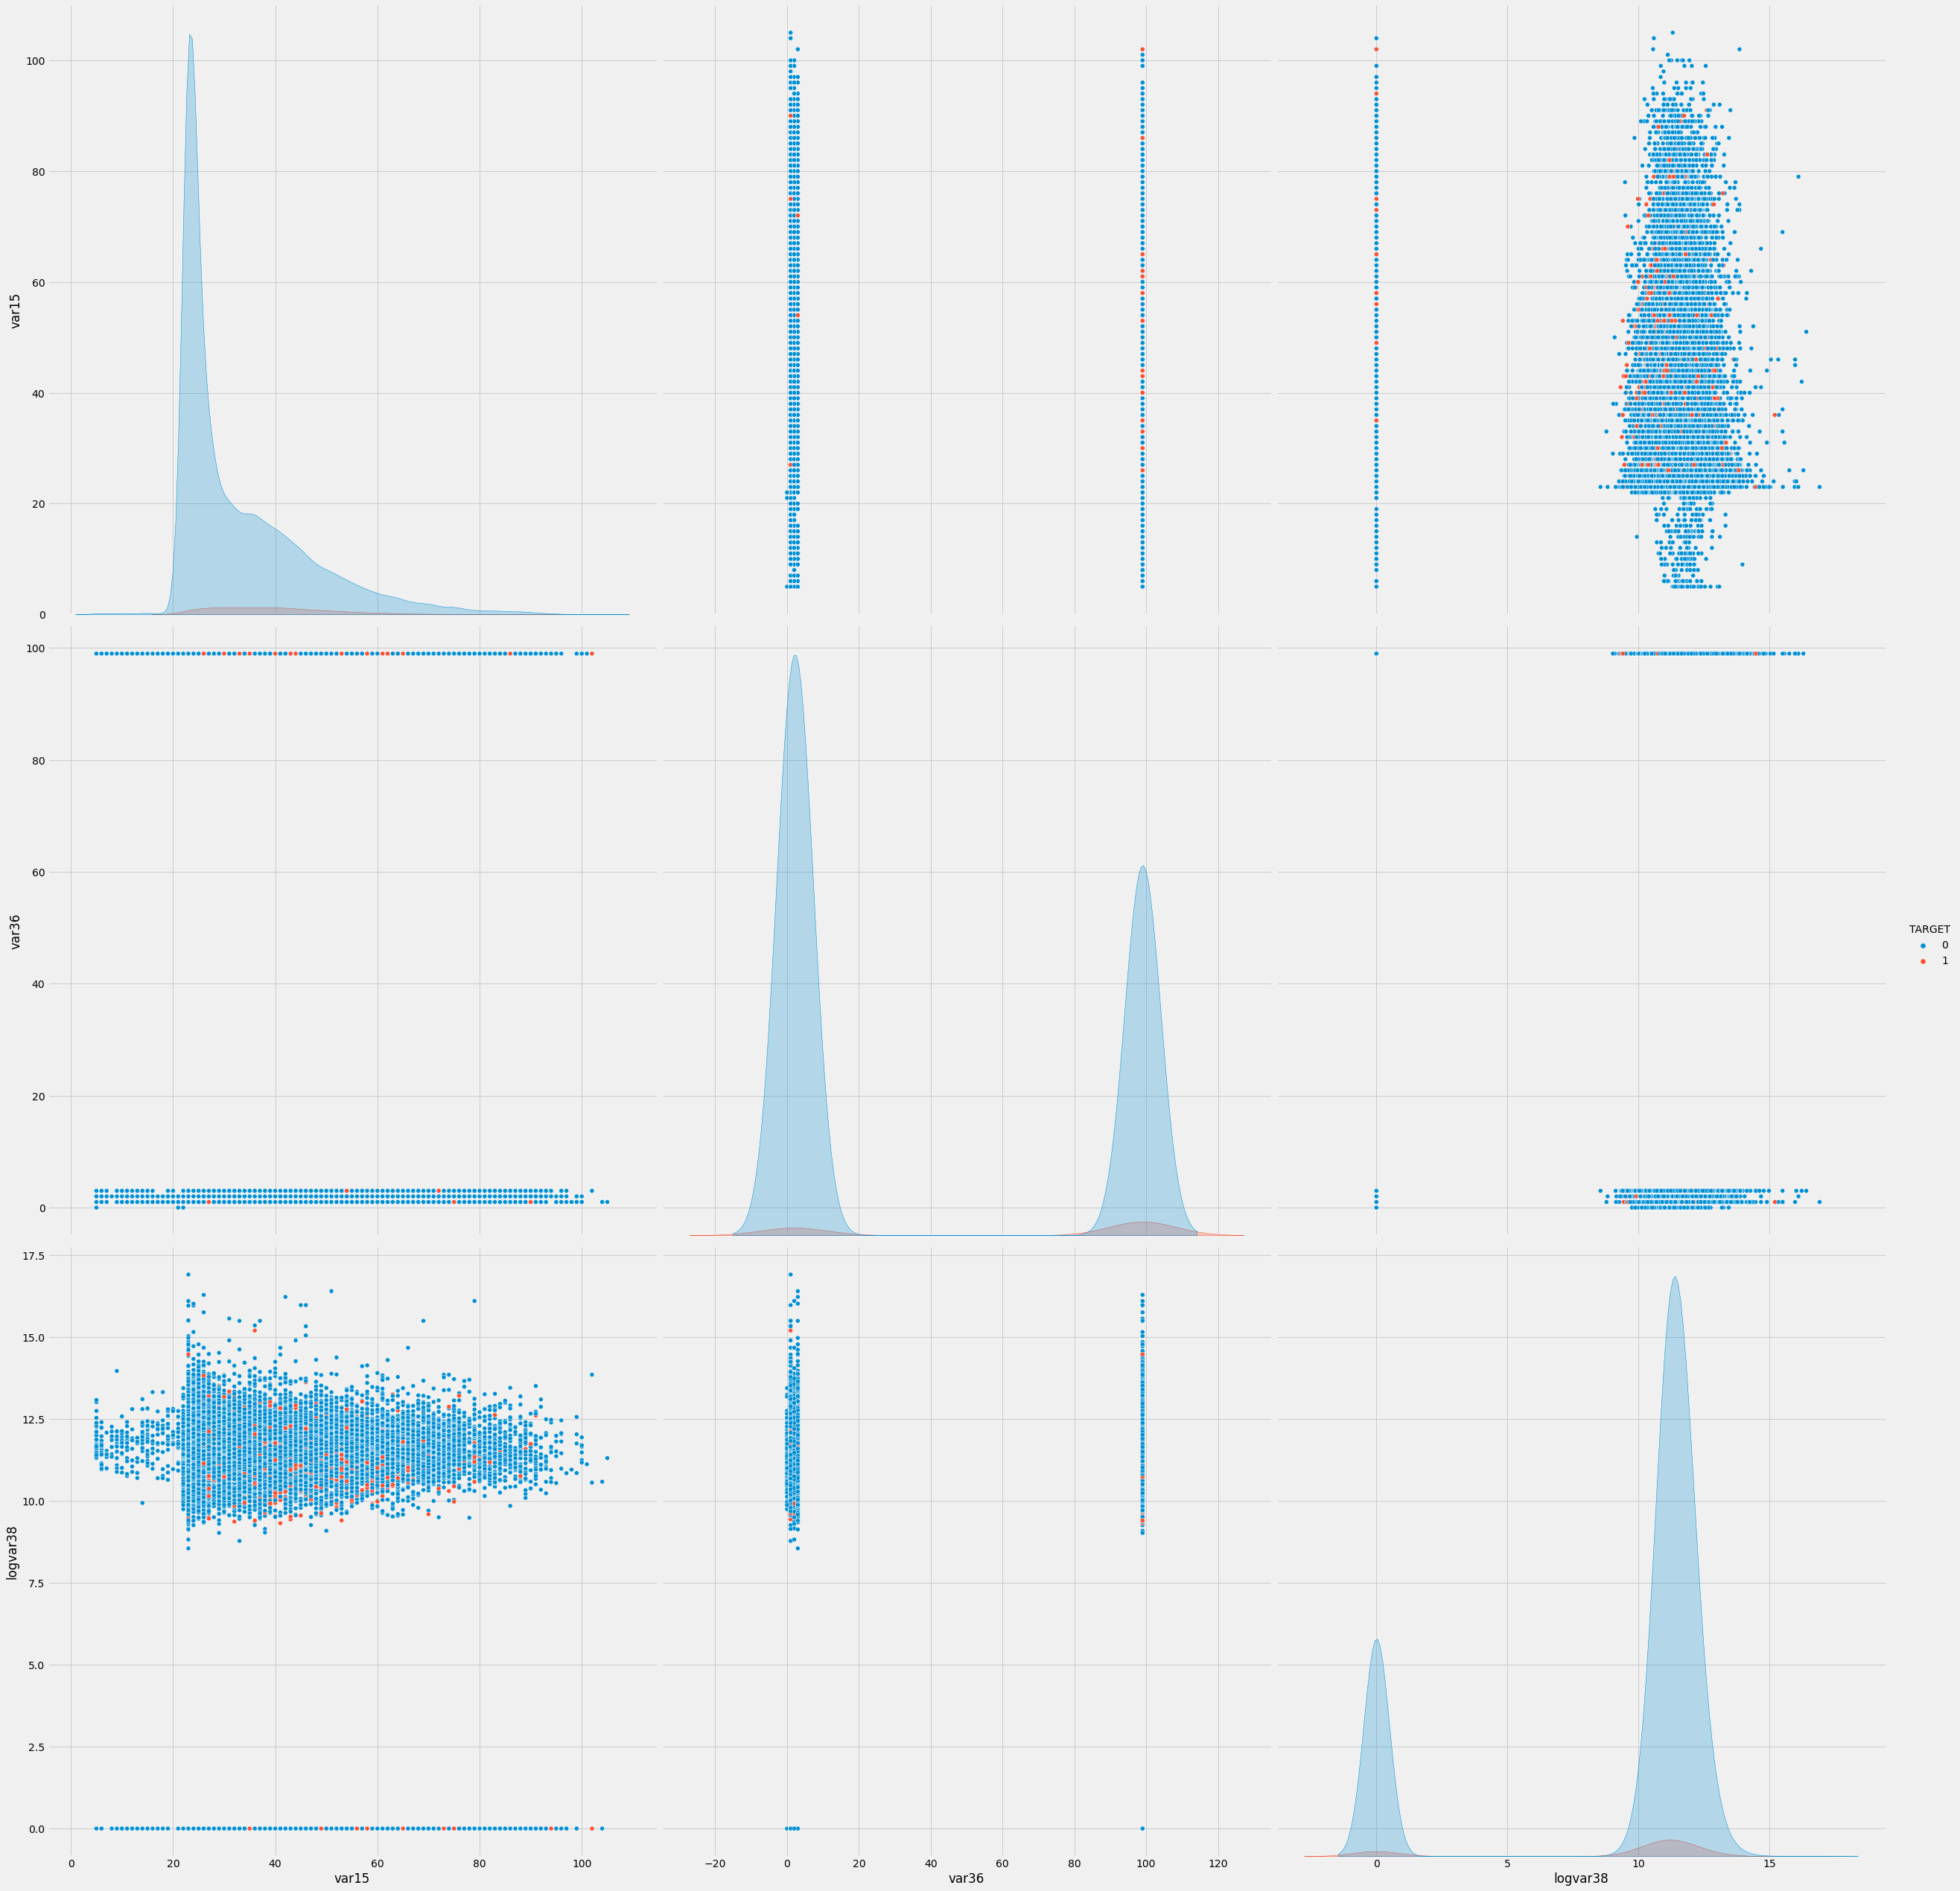

In [97]:
sns.pairplot(train[['var15', 'var36', 'logvar38', 'TARGET']], hue='TARGET', size=12, diag_kind='kde');

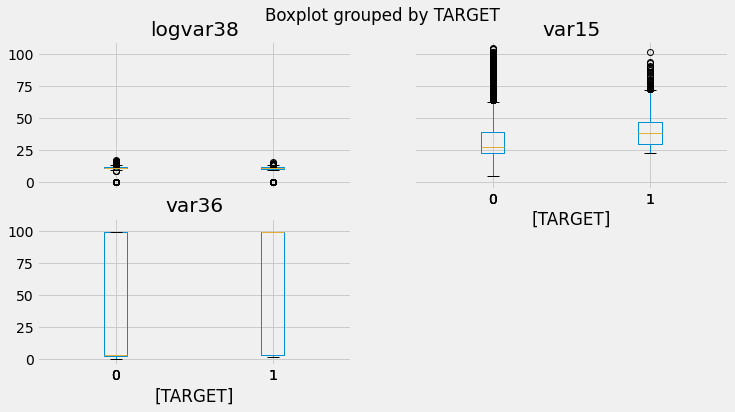

In [98]:
train[['var15', 'var36', 'logvar38', 'TARGET']].boxplot(by='TARGET', figsize=(12, 6));

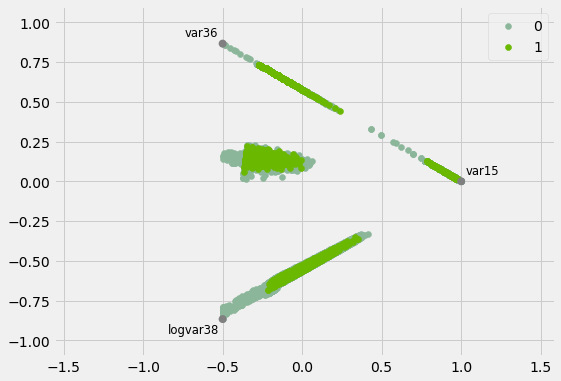

In [105]:
# A final multivariate visualization technique pandas has is radvis
# Which puts each feature as a point on a 2D plane, and then simulates
# having each sample attached to those points through a spring weighted
# by the relative value for that feature
from pandas.plotting import radviz
radviz(train[['var15', 'var36', 'logvar38', 'TARGET']], 'TARGET');

#### now look at all 8 features together

In [106]:
features

['var15',
 'ind_var5',
 'ind_var8_0',
 'ind_var30',
 'num_var5',
 'num_var30',
 'num_var42',
 'var36',
 'num_meses_var5_ult3']

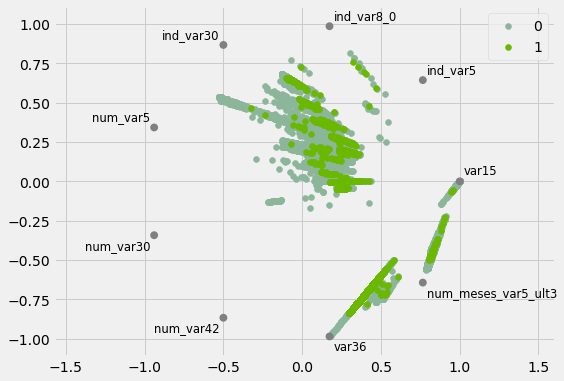

In [108]:
radviz(train[features + ['TARGET']], 'TARGET');

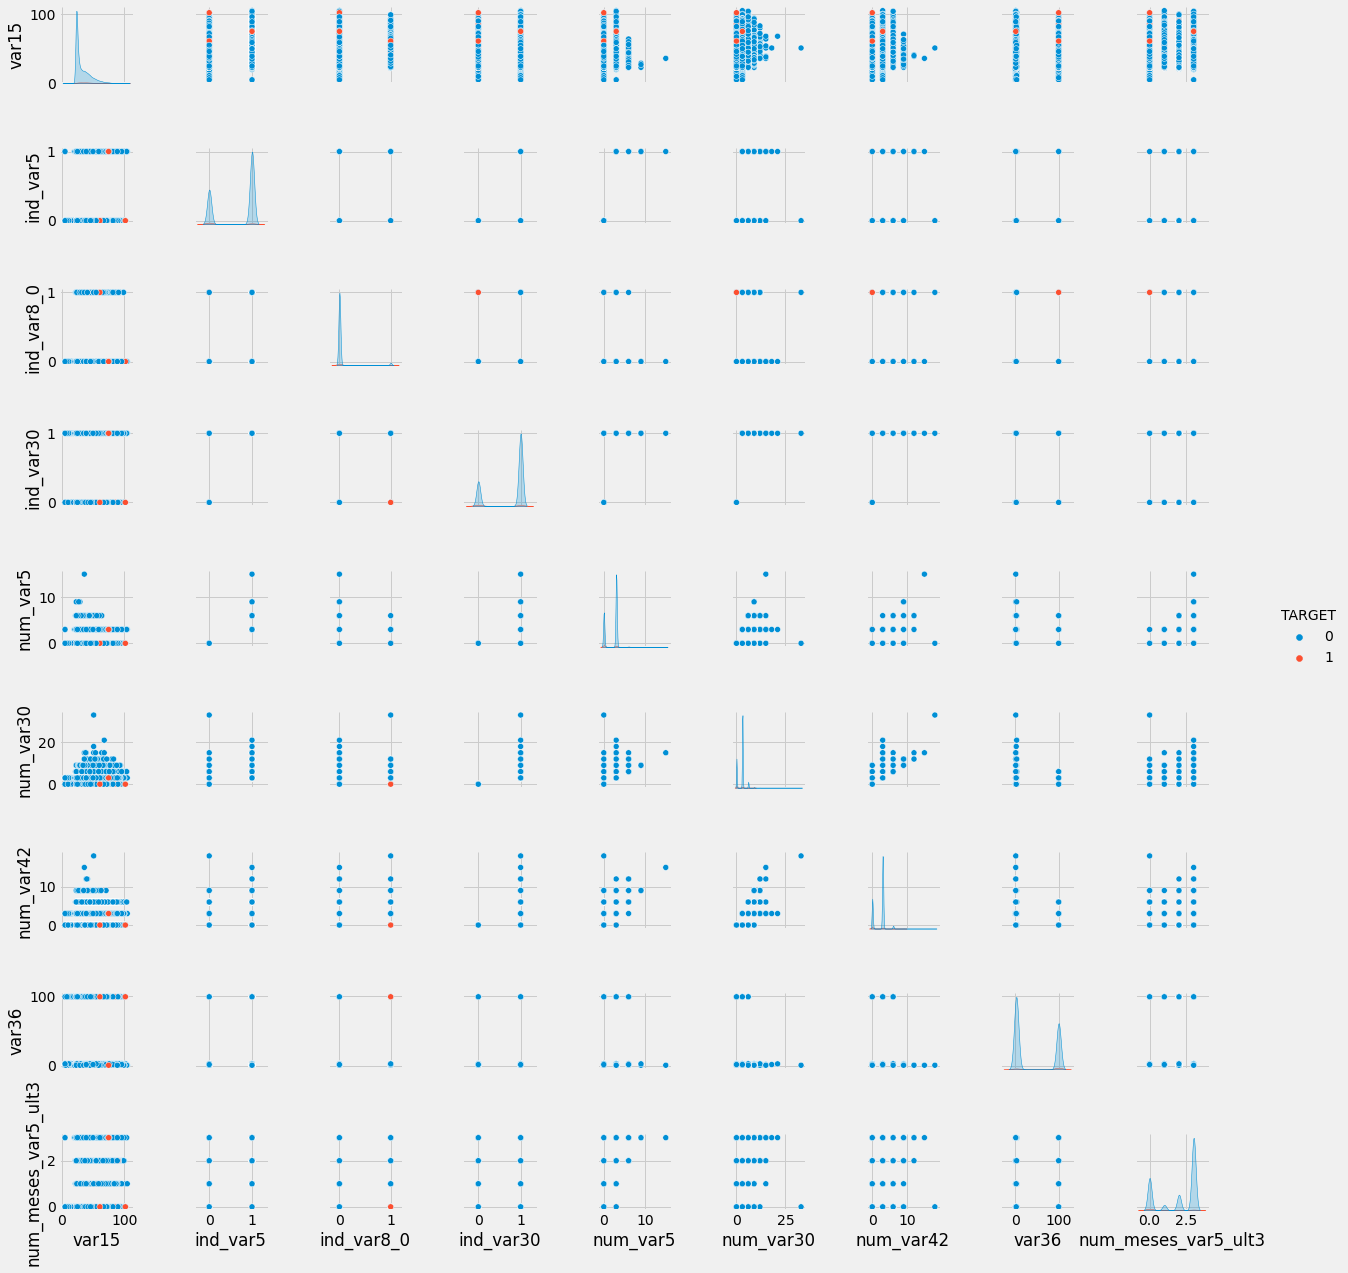

In [110]:
sns.pairplot(train[features + ['TARGET']], hue='TARGET', size=2, diag_kind='kde');

### Correlations

In [111]:
cor_mat = X.corr()

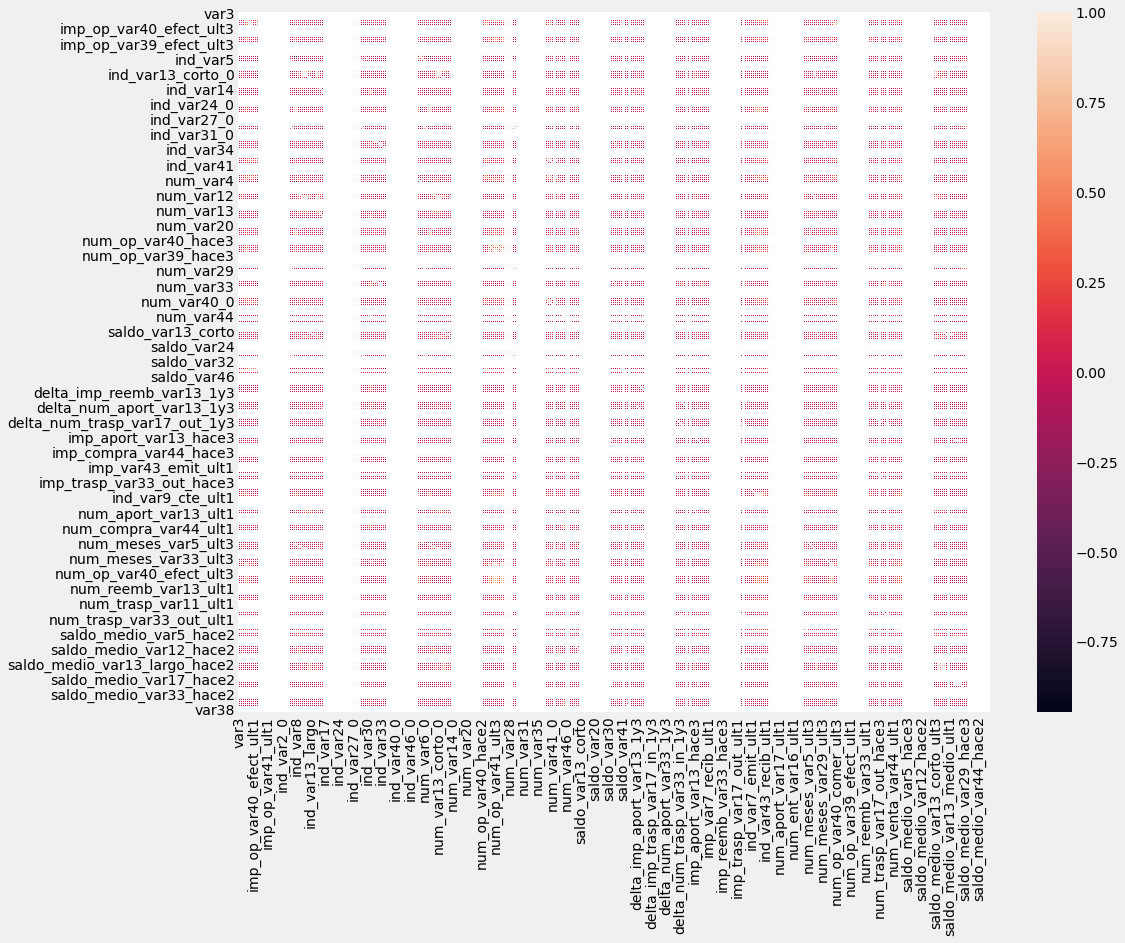

In [112]:
f, ax = plt.subplots(figsize=(15, 12))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor_mat, linewidths=.5, ax=ax);

In [113]:
cor_mat = X_sel.corr()

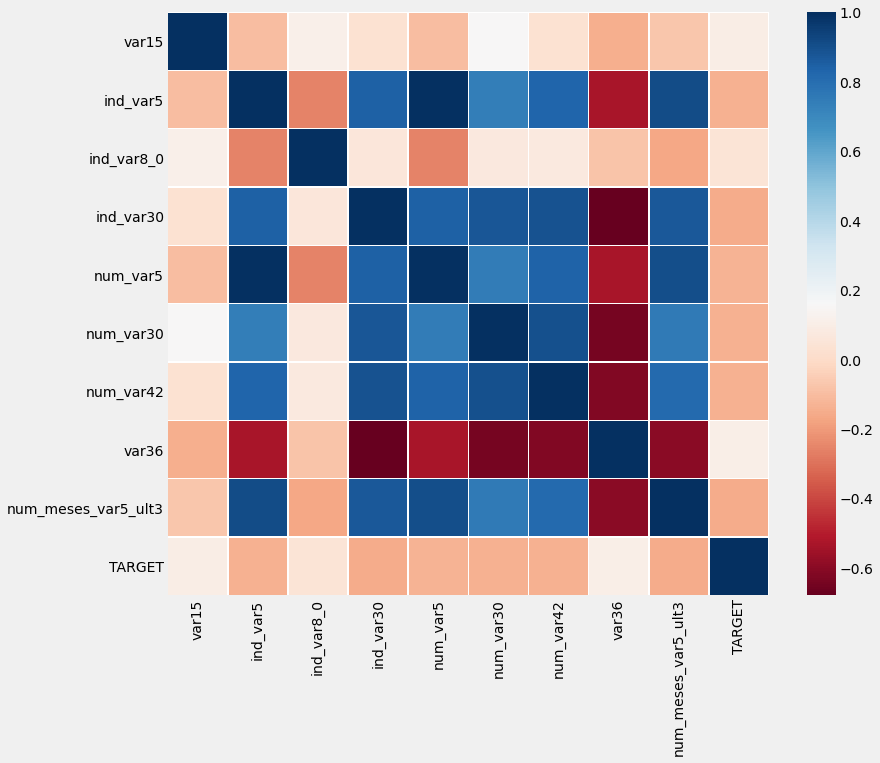

In [118]:
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12, 10))
sns.heatmap(cor_mat, linewidths=.5, cmap='RdBu');

In [131]:
# only important correlations and not auto-correlations
threshold = 0.7
important_corrs = (cor_mat[abs(cor_mat) > threshold][cor_mat != 1.0]).unstack().dropna().to_dict()
unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) for key in important_corrs])),
    columns=['attribute pair', 'correlation']
)

# sorted by absolute value
unique_important_corrs = unique_important_corrs.loc[abs(unique_important_corrs['correlation']).argsort()[::-1]]
unique_important_corrs

,attribute pair,correlation
7,"(ind_var5, num_var5)",0.993709
5,"(ind_var5, num_meses_var5_ult3)",0.908842
9,"(num_meses_var5_ult3, num_var5)",0.903272
10,"(num_var30, num_var42)",0.898119
13,"(ind_var30, num_var42)",0.894182
2,"(ind_var30, num_var30)",0.875812
8,"(ind_var30, num_meses_var5_ult3)",0.869045
6,"(ind_var30, ind_var5)",0.848338
14,"(ind_var30, num_var5)",0.843001
4,"(num_var42, num_var5)",0.839574


### Train Test 분리

In [140]:
from sklearn.model_selection import train_test_split

X = X.drop('n0', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape: {}, 테스트 세트 Shape: {}'.format(X_train.shape, X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts() / train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts() / test_cnt)

학습 세트 Shape: (60816, 369), 테스트 세트 Shape: (15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960668
1    0.039332
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.959484
1    0.040516
Name: TARGET, dtype: float64


### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [134]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로 설정
xgb = XGBClassifier(n_estimators=500, random_state=13)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb.fit(X_train, y_train,
        early_stopping_rounds=100,
        eval_metric='auc',
        eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1], average='macro')
print(f'ROC AUC: {xgb_roc_score:.4f}')

[0]	validation_0-auc:0.804067	validation_1-auc:0.7962
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.808118	validation_1-auc:0.799658
[2]	validation_0-auc:0.815486	validation_1-auc:0.805864
[3]	validation_0-auc:0.81712	validation_1-auc:0.809316
[4]	validation_0-auc:0.816845	validation_1-auc:0.80908
[5]	validation_0-auc:0.816957	validation_1-auc:0.808787
[6]	validation_0-auc:0.817776	validation_1-auc:0.80924
[7]	validation_0-auc:0.817339	validation_1-auc:0.809426
[8]	validation_0-auc:0.817286	validation_1-auc:0.809481
[9]	validation_0-auc:0.817569	validation_1-auc:0.809569
[10]	validation_0-auc:0.817364	validation_1-auc:0.809354
[11]	validation_0-auc:0.8176	validation_1-auc:0.809308
[12]	validation_0-auc:0.818039	validation_1-auc:0.809888
[13]	validation_0-auc:0.81824	validation_1-auc:0.809834
[14]	validation_0-auc:0.818567	validation_1-auc:0.810482
[15]	

* *max_depth, min_child_weight, colsample_bytree* 하이퍼 파라미터 튜닝
* 학습 시간이 많이 필요한 ML 모델인 경우에 하이퍼 파라미터 튜닝을 수행하는 요령:
    1. 2~3개 정도의 파라미터를 결합해 최적 파라미터를 찾아낸 뒤에 이 최적 파라미터를 기반으로 다시 1~2개 파라미터를 결합해 파라미터 튜닝을 수행하는 것

In [135]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb = XGBClassifier(n_estimators=100)

params = {
    'max_depth': [5, 7],
    'min_child_weight': [1, 3],
    'colsample_bytree': [0.5, 0.75]
}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb, param_grid=params, cv=3)
gridcv.fit(X_train, y_train,
           early_stopping_rounds=30,
           eval_metric='auc',
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터: ', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print(f'ROC AUC: {xgb_roc_score:.4f}')

[0]	validation_0-auc:0.710619	validation_1-auc:0.698283
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.817339	validation_1-auc:0.798903
[2]	validation_0-auc:0.811636	validation_1-auc:0.794707
[3]	validation_0-auc:0.819132	validation_1-auc:0.80295
[4]	validation_0-auc:0.827488	validation_1-auc:0.813592
[5]	validation_0-auc:0.824512	validation_1-auc:0.8101
[6]	validation_0-auc:0.820388	validation_1-auc:0.80594
[7]	validation_0-auc:0.826621	validation_1-auc:0.812026
[8]	validation_0-auc:0.833806	validation_1-auc:0.819826
[9]	validation_0-auc:0.833508	validation_1-auc:0.817419
[10]	validation_0-auc:0.835737	validation_1-auc:0.819127
[11]	validation_0-auc:0.838561	validation_1-auc:0.822632
[12]	validation_0-auc:0.840582	validation_1-auc:0.82318
[13]	validation_0-auc:0.839832	validation_1-auc:0.823431
[14]	validation_0-auc:0.838804	validation_1-auc:0.822315
[15

In [138]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가
xgb = XGBClassifier(n_estimators=1000, 
                    learning_rate=0.02, 
                    max_depth=5,
                    min_child_weight=3,
                    col_sample_bytree=0.5,
                    reg_alpha=0.03,
                    random_state=13)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb.fit(X_train, y_train,
        early_stopping_rounds=200,
        eval_metric='auc',
        eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1], average='macro')
print(f'ROC AUC: {xgb_roc_score:.4f}')

[0]	validation_0-auc:0.818857	validation_1-auc:0.804934
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.819249	validation_1-auc:0.80623
[2]	validation_0-auc:0.819529	validation_1-auc:0.806094
[3]	validation_0-auc:0.820196	validation_1-auc:0.806225
[4]	validation_0-auc:0.820608	validation_1-auc:0.806376
[5]	validation_0-auc:0.821011	validation_1-auc:0.807297
[6]	validation_0-auc:0.821164	validation_1-auc:0.807415
[7]	validation_0-auc:0.825366	validation_1-auc:0.813748
[8]	validation_0-auc:0.825735	validation_1-auc:0.813554
[9]	validation_0-auc:0.82748	validation_1-auc:0.816665
[10]	validation_0-auc:0.828842	validation_1-auc:0.817658
[11]	validation_0-auc:0.829253	validation_1-auc:0.818533
[12]	validation_0-auc:0.829764	validation_1-auc:0.818351
[13]	validation_0-auc:0.829851	validation_1-auc:0.818383
[14]	validation_0-auc:0.829884	validation_1-auc:0.818504

앙상블 계열 알고리즘에서 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격하게 되는 경우는 많지 않다.  
(앙상블 계열 알고리즘은 과적합이나 잡음에 기본적으로 뛰어난 알고리즘이기 때문)

<Figure size 720x576 with 0 Axes>

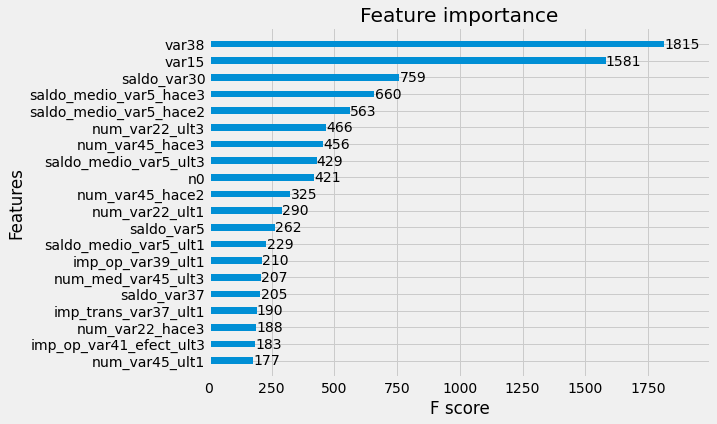

In [142]:
# feature importance
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(xgb, max_num_features=20, height=0.4)
plt.show()

'n0'은 지우고 학습하는게 맞았겠다.  
로그 스케일 취하고 var38 만들어준건 의미가 없네

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [144]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm.fit(X_train, y_train,
         early_stopping_rounds=100,
         eval_metric='auc',
         eval_set=evals,
         verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1], average='macro')
print(f"ROC AUC: {lgbm_roc_score:.4f}")

[1]	valid_0's binary_logloss: 0.16127	valid_0's auc: 0.80841
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.156296	valid_0's auc: 0.811803
[3]	valid_0's binary_logloss: 0.152859	valid_0's auc: 0.816459
[4]	valid_0's binary_logloss: 0.150111	valid_0's auc: 0.826764
[5]	valid_0's binary_logloss: 0.148112	valid_0's auc: 0.82991
[6]	valid_0's binary_logloss: 0.146376	valid_0's auc: 0.831116
[7]	valid_0's binary_logloss: 0.144876	valid_0's auc: 0.83171
[8]	valid_0's binary_logloss: 0.143672	valid_0's auc: 0.832607
[9]	valid_0's binary_logloss: 0.142692	valid_0's auc: 0.833051
[10]	valid_0's binary_logloss: 0.141919	valid_0's auc: 0.833309
[11]	valid_0's binary_logloss: 0.141186	valid_0's auc: 0.833304
[12]	valid_0's binary_logloss: 0.140511	valid_0's auc: 0.834873
[13]	valid_0's binary_logloss: 0.140065	valid_0's auc: 0.834889
[14]	valid_0's binary_logloss: 0.139644	valid_0's auc: 0.83462
[15]	valid_0's binary_logloss: 0.139294	valid_0's auc: 

In [ ]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm = LGBMClassifier(n_estimators=200)

params = {
    'num_leaves': [32, 64],
    'max_depth': [128, 160], # 확실히 깊게 하네
    'min_child_samples': [60, 100],
    'subsample': [0.8, 1]
}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm, param=parmas, cv=3)
gridcv.fit(X_train, y_train,
           early_stopping_rounds=30,
           eval_metric='auc',
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터: ', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print(f'ROC AUC: {lgbm_roc_score:.4f}')